* Pascal VOCデータでセマンティックセグメンテーション
* モデルはConvolution→Deconvolutionによる基本的なネットワーク

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from tqdm import tqdm
from PIL import Image, ImageEnhance

import warnings
warnings.filterwarnings('ignore')

In [3]:
!ls ./data/VOCdevkit/VOC2007

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [4]:
f = open('./data/VOCdevkit/VOC2007/ImageSets/Segmentation/train.txt')
train_data = [(
                            './data/VOCdevkit/VOC2007/JPEGImages/'+row.replace('\n', '')+'.jpg', 
                            './data/VOCdevkit/VOC2007/SegmentationClass/'+row.replace('\n', '')+'.png'
                        ) for row in f.readlines()]
f.close()

f = open('./data/VOCdevkit/VOC2007/ImageSets/Segmentation/val.txt')
valid_data = [(
                            './data/VOCdevkit/VOC2007/JPEGImages/'+row.replace('\n', '')+'.jpg', 
                            './data/VOCdevkit/VOC2007/SegmentationClass/'+row.replace('\n', '')+'.png'
                        ) for row in f.readlines()]
f.close()

len(train_data), len(valid_data)

(209, 213)

In [5]:
label_names = (
    'background',
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor',
)
len(label_names)

21

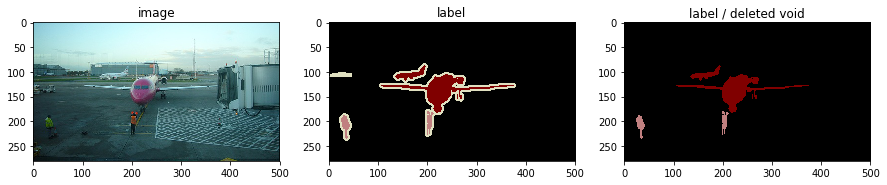

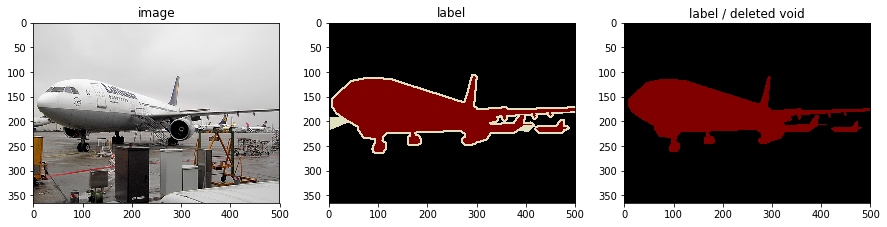

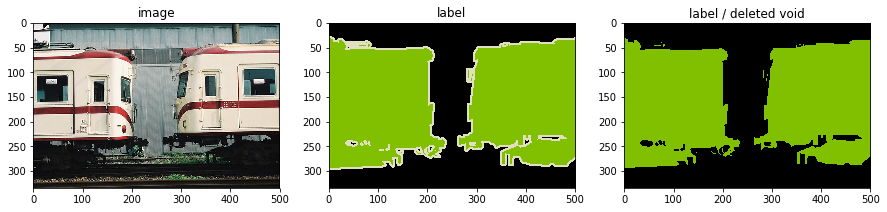

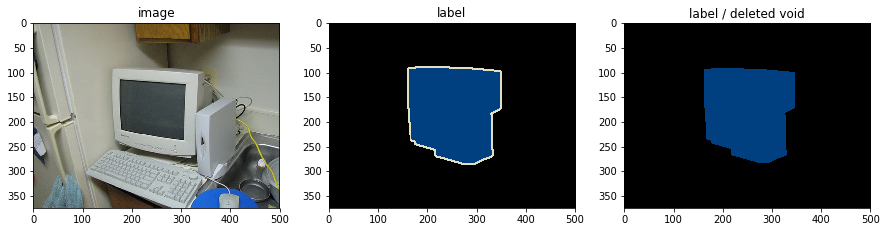

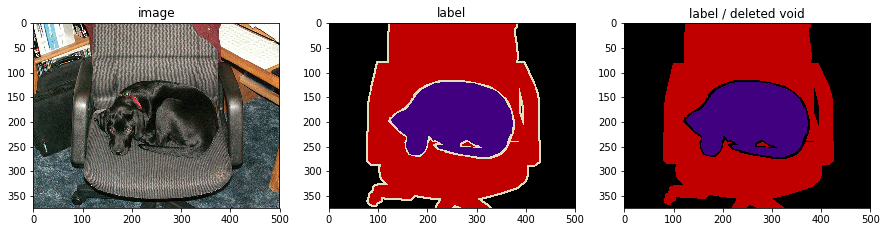

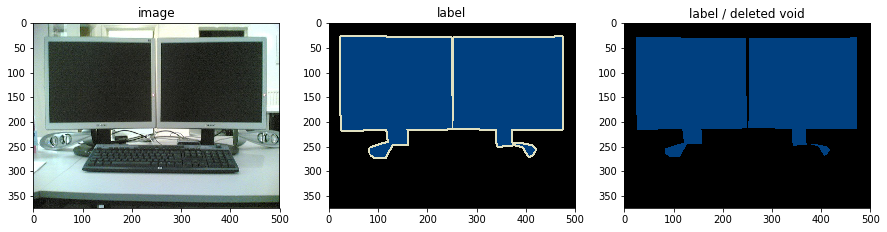

In [6]:
for path_image, path_label in train_data[:3]:
    
    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

    image = Image.open(path_image)
    axs[0].imshow(image)
    axs[0].set_title('image')
    
    label = Image.open(path_label)
    axs[1].imshow(label)
    axs[1].set_title('label')
    
    palette = label.getpalette()
    label = np.array(label)
    label[np.where(label == 255)] = 0 # 境界線ラベルは背景ラベルに変更
    label = Image.fromarray(label, mode='P')
    label.putpalette(palette)
    axs[2].imshow(label)
    axs[2].set_title('label / deleted void')
    
    plt.show()
    
for path_image, path_label in valid_data[:3]:
    
    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

    image = Image.open(path_image)
    axs[0].imshow(image)
    axs[0].set_title('image')
    
    label = Image.open(path_label)
    axs[1].imshow(label)
    axs[1].set_title('label')
    
    palette = label.getpalette()
    label = np.array(label)
    label[np.where(label == 255)] = 0 # 境界線ラベルは背景ラベルに変更
    label = Image.fromarray(label, mode='P')
    label.putpalette(palette)
    axs[2].imshow(label)
    axs[2].set_title('label / deleted void')
    
    plt.show()

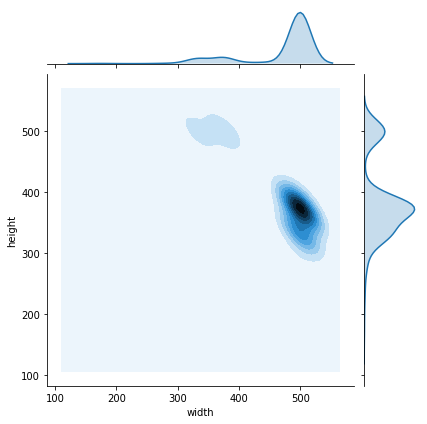

In [7]:
ws = []
hs = []

for path_image, _ in train_data:
    
    image = Image.open(path_image)
    w, h = image.size
    ws.append(w)
    hs.append(h)

for path_image, _ in valid_data:
    
    image = Image.open(path_image)
    w, h = image.size
    ws.append(w)
    hs.append(h)

ws = pd.Series(ws, name='width')
hs = pd.Series(hs, name='height')
sns.jointplot(ws, hs, kind='kde')
plt.show()

In [8]:
def read_image_label(image, label, augmentation, crop_size, show=False):

    # image and label is PIL.Image
    w, h = image.size
    w_crop, h_crop = crop_size
    
    x0 = (w // 2) - (w_crop // 2)
    x1 = (w // 2) + (w_crop // 2)
    y0 = (h // 2) - (h_crop // 2)
    y1 = (h // 2) + (h_crop // 2)
    
    if augmentation:
        
        # flip
        if np.random.random() > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            label = label.transpose(Image.FLIP_LEFT_RIGHT)
            
        # shift
        if np.random.random() > 0.5:
            dx = np.random.randint(-w_crop // 20, w_crop // 20)
            dy = np.random.randint(-h_crop // 20, h_crop // 20)
            x0 = max(0, int(x0 + dx))
            y0 = max(0, int(y0 + dy))
            x1 = min(w, int(x1 + dx))
            y1 = min(h, int(y1 + dy))
            
        # scale
        if np.random.random() > 0.5:
            r = np.random.uniform(0, 0.25)
            x0 = int(x0 + w_crop * r)
            y0 = int(y0 + h_crop * r)
            x1 = int(x1 - w_crop * r)
            y1 = int(y1 - h_crop * r)
            
        # change brightness
        if np.random.random() > 0.5:
            r = np.random.uniform(0.8, 1)
            image = ImageEnhance.Brightness(image).enhance(r)

    image = image.crop((x0, y0, x1, y1))
    image = image.resize(crop_size, Image.ANTIALIAS)
    
    label = label.crop((x0, y0, x1, y1))
    label = label.resize(crop_size, Image.NEAREST)
    
    if show:
        return image, label
    
    else:
        image = np.array(image, dtype=np.float32)
        image /= 255
        image = image.transpose(2, 0, 1)
        label = np.array(label, dtype=np.int32)
        return image, label

In [9]:
train_data2 = []

for path_image, path_label in train_data:
    
    image = Image.open(path_image)
    w, h = image.size
    
    if w > 410 and h < 550:
        train_data2.append((path_image, path_label))
        
valid_data2 = []

for path_image, path_label in valid_data:
    
    image = Image.open(path_image)
    w, h = image.size
    
    if w > 410 and h < 550:
        valid_data2.append((path_image, path_label))
        
len(train_data2), len(valid_data2)

(171, 174)

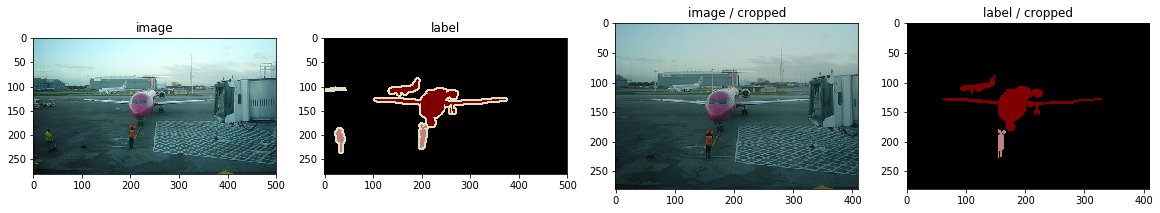

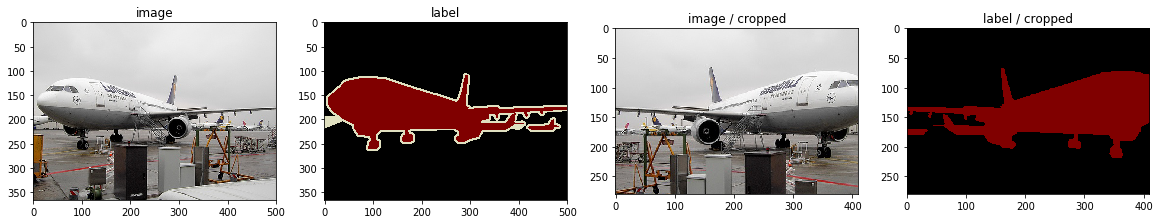

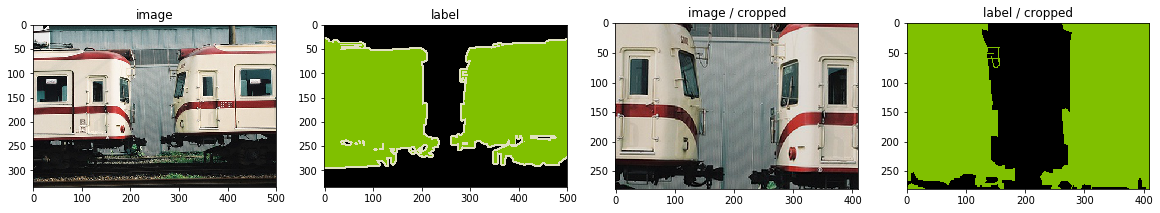

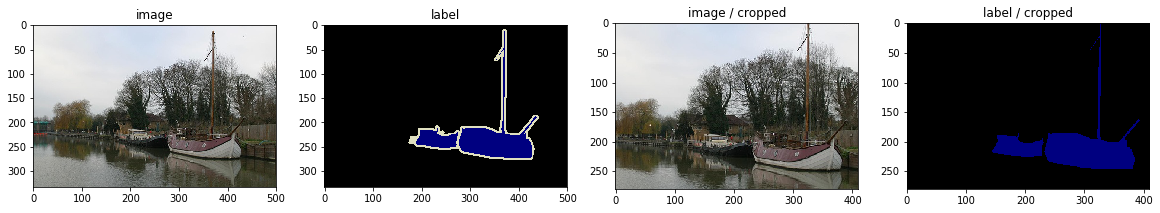

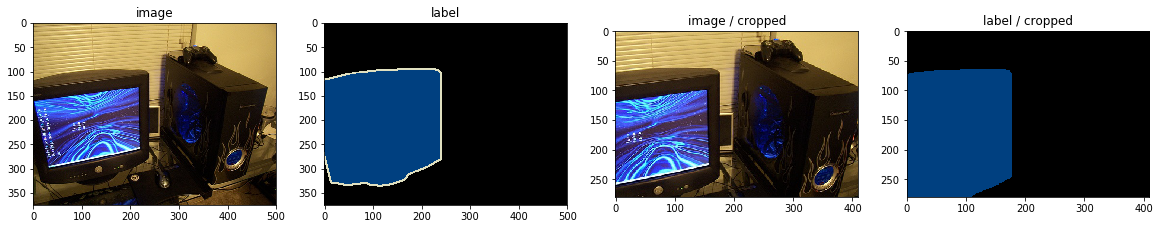

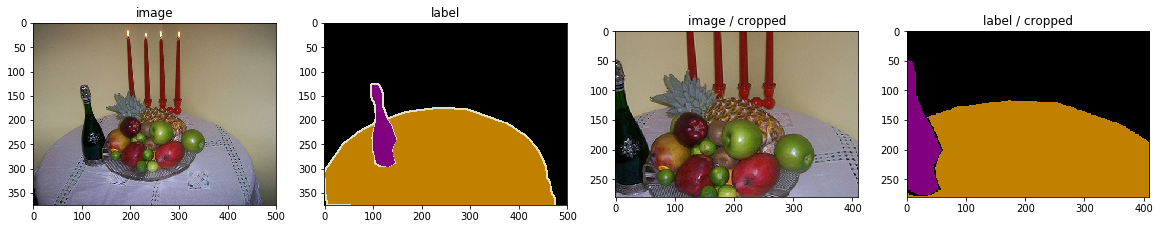

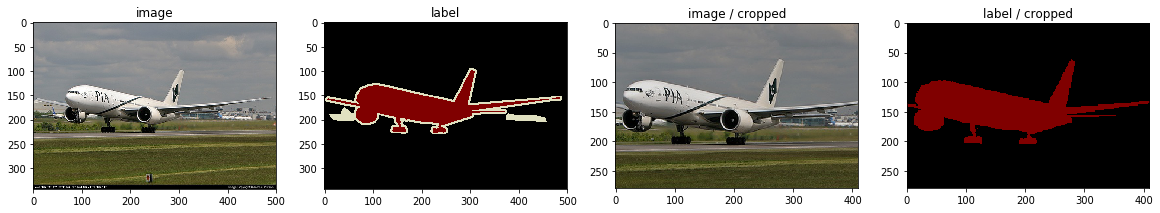

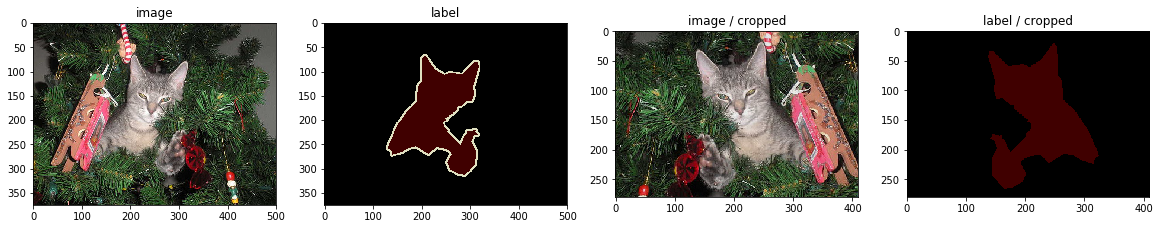

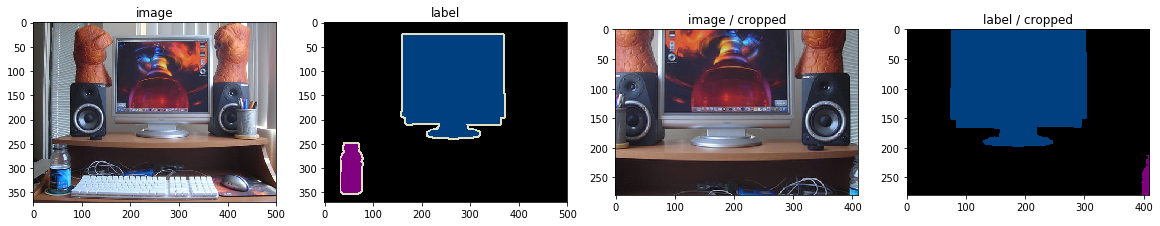

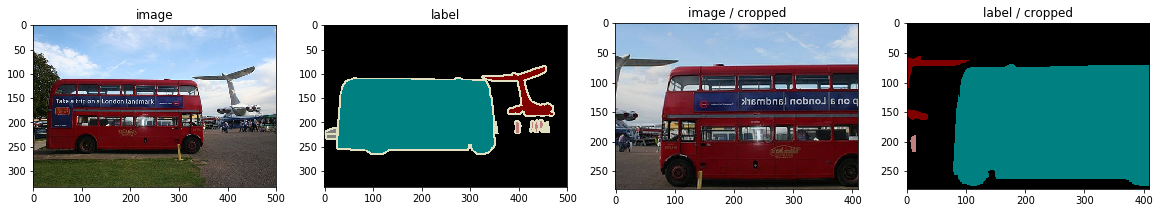

In [10]:
for path_image, path_label in train_data2[:10]:
    
    fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

    image = Image.open(path_image)
    axs[0].imshow(image)
    axs[0].set_title('image')
    
    label = Image.open(path_label)
    axs[1].imshow(label)
    axs[1].set_title('label')
    
    palette = label.getpalette()
    label = np.array(label)
    label[np.where(label == 255)] = 0 # 境界線ラベルは背景ラベルに変更
    label = Image.fromarray(label, mode='P')
    label.putpalette(palette)
    
    image_cropped, label_cropped = read_image_label(image, label, augmentation=True, crop_size=(410, 280), show=True)
    
    axs[2].imshow(image_cropped)
    axs[2].set_title('image / cropped')

    axs[3].imshow(label_cropped)
    axs[3].set_title('label / cropped')
    
    plt.show()

In [11]:
class Dataset(chainer.dataset.DatasetMixin):
    
    def __init__(self, data, crop_size):
        
        self.data = data
        self.crop_size = crop_size

    def __len__(self):
        
        return len(self.data)

    def get_example(self, i):
        
        path_image, path_label = self.data[i]
        
        image = Image.open(path_image)
        label = Image.open(path_label)
    
        palette = label.getpalette()
        label = np.array(label)
        label[np.where(label == 255)] = 0 # 境界線ラベルは背景ラベルに変更
        label = Image.fromarray(label, mode='P')
        label.putpalette(palette)
        
        x, y = read_image_label(image, label, augmentation=chainer.config.train, crop_size=self.crop_size)
        return x, y

In [12]:
train_dataset = Dataset(train_data2, crop_size=(410, 280))
valid_dataset = Dataset(valid_data2, crop_size=(410, 280))

In [13]:
class Model(chainer.Chain):

    def __init__(self):
        
        super().__init__()
        
        with self.init_scope():
            
            self.conv0=L.Convolution2D(3, 32, ksize=3)
            self.conv1=L.Convolution2D(32, 64, ksize=3)
            self.conv2=L.Convolution2D(64, 128, ksize=3)
            self.conv3=L.Convolution2D(128, 256, ksize=3)
            self.deconv4=L.Deconvolution2D(256, 128, ksize=3)
            self.deconv5=L.Deconvolution2D(128, 64, ksize=3)
            self.deconv6=L.Deconvolution2D(64, 32, ksize=3)
            self.conv7=L.Convolution2D(32, len(label_names), ksize=3, pad=2)

            self.bn0=L.BatchNormalization(32)
            self.bn1=L.BatchNormalization(64)
            self.bn2=L.BatchNormalization(128)
            self.bn3=L.BatchNormalization(256)
            self.bn4=L.BatchNormalization(128)
            self.bn5=L.BatchNormalization(64)
            self.bn6=L.BatchNormalization(32)

    def __call__(self, x):
        
        h = F.relu(self.bn0(self.conv0(x)))
        h = F.relu(self.bn1(self.conv1(h)))
        h = F.relu(self.bn2(self.conv2(h)))
        h = F.relu(self.bn3(self.conv3(h)))
        h = F.relu(self.bn4(self.deconv4(h)))
        h = F.relu(self.bn5(self.deconv5(h)))
        h = F.relu(self.bn6(self.deconv6(h)))        
        y = self.conv7(h)
        
        return y

In [14]:
model = Model()

In [15]:
# test

x, y = train_dataset.get_example(0)
x = x[np.newaxis]

pred = model(x)
pred.shape

(1, 21, 280, 410)

In [16]:
gpu = 0

model = L.Classifier(Model())
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

if gpu >= 0:
    
    chainer.cuda.get_device(gpu).use()
    model.to_gpu()

In [17]:
epoch_num = 100
batch_size = 16

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(valid_dataset, batch_size, repeat=False, shuffle=False)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = chainer.training.Trainer(updater, (epoch_num, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu), trigger=(20, 'epoch'))
trainer.extend(extensions.LogReport(trigger=(10, 'epoch')))
trainer.extend(extensions.snapshot_object(model, filename='model_epoch_{.updater.epoch}.npz'))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
10          1.61902                           0.620285                                 89.9386       
20          1.4287      1.4605                0.652214       0.688063                  181.7         
30          1.38817                           0.657641                                 270.812       
40          1.36311     1.44189               0.658804       0.689553                  362.837       
50          1.33899                           0.660071                                 451.874       
60          1.31832     1.44797               0.660965       0.68833                   543.991       
70          1.28639                           0.666952                                 633.216       
80          1.28195     1.45699               0.662997       0.680503                  724.416       
90          1.26448                           0.665089                              